In [1]:
import os
import shutil
import numpy as np

from matplotlib import pyplot as plt 

import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
import keras
from keras import backend as K
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Input, Lambda, Dense, BatchNormalization, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.models import Model
from keras.optimizers import Adam, Adagrad, SGD, RMSprop
from keras.utils import to_categorical
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
%matplotlib inline

In [2]:
# pip install split-folders

In [ ]:
# ! pip install python_splitter 


In [ ]:
# import python_splitter

python_splitter.split_from_folder("BETON", train=0.5, test=0.3, val=0.2)

In [ ]:
# import splitfolders

image_directory= "BETON"
splitfolders.ratio(image_directory, output="output",
        seed=42, ratio=(0.7, 0.15, 0.15), group_prefix=None, move=False) # default values

In [ ]:
# pip install split-folders[full]

In [ ]:
# splitfolders.ratio("data", output="output",
#     seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

In [15]:
# Set seed
from numpy.random import seed
seed(42)
# from tensorflow import set_random_seed
# from tensorflow.random import set_seed 
tensorflow.random.set_seed(42)

# Global variables
# BATCH_SIZE = 128
BATCH_SIZE = 128
TARGET_SIZE=(224, 224)  # Resize input images to that size
INPUT_SHAPE = TARGET_SIZE + (3,)
NUM_CLASSES = 2  
DATA_PATH = "C:\\Users\\jarosquin\\Documents\\toits\\image_classifier_2\\output" # Root data path
TRAIN_PATH = os.path.join(DATA_PATH, 'train')  # Train data path 
VAL_PATH = os.path.join(DATA_PATH, 'val')  # Validation data path

In [16]:
print(tensorflow.random.uniform([1]))  # generates 'A1'
print(tensorflow.random.uniform([1]))  # generates 'A2'

tf.Tensor([0.6645621], shape=(1,), dtype=float32)
tf.Tensor([0.68789124], shape=(1,), dtype=float32)


In [17]:
def classes_stat(image_iterator):
    """
    Function to print how many items per class has `image_iterator`.
    Returns dictionary `class_idx` to match class index to label
    """
    classes = image_iterator.classes
    class_idx = {v:k for k, v in image_iterator.class_indices.items()}
    for c in np.unique(classes):
        count = np.sum(classes==c)
        print('Class {} ({}): {} items'.format(c, class_idx[c], count))
    return class_idx

In [18]:
def image_plots(imgs, figsize=(12,8), rows=1, interp=False, titles=None):
    """
    Function to plot images from `imgs` array with optional labels from `titles`.
    Images will be plot in one figure with number of `rows`. 
    """
    f = plt.figure(figsize=figsize)
    cols = len(imgs)//rows if len(imgs) % 2 == 0 else len(imgs)//rows + 1
    for i in range(len(imgs)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=12)
        plt.imshow(imgs[i], interpolation=None if interp else 'none')

In [19]:
# Create image generator to read images from directory 
# and rescale pixel values from range [0; 255] to [0;1] 
image_gen = ImageDataGenerator(rescale=1.0/255)
train_iterator = image_gen.flow_from_directory(TRAIN_PATH, 
                                               batch_size=BATCH_SIZE, 
                                               target_size=TARGET_SIZE)

Found 6400 images belonging to 4 classes.


In [20]:
# How many images per class?
_ = classes_stat(train_iterator)

Class 0 (ARDOISES): 1600 items
Class 1 (BETON): 1600 items
Class 2 (TUILES): 1600 items
Class 3 (ZINC ALUMINIUM): 1600 items


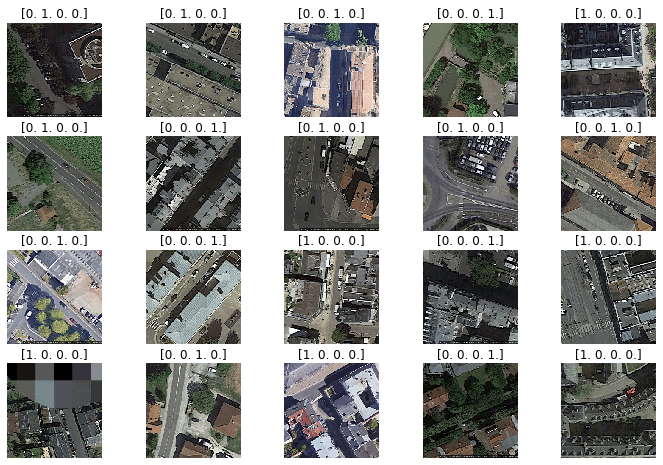

In [21]:
# Read batch of data
bx, by = next(train_iterator)

# Show images
image_plots(imgs=bx[:20], titles=by[:20], rows=4)

In [22]:
# Use custom validation dataset
VAL_PATH = os.path.join(DATA_PATH, 'val')
# Create image iterator
val_iterator = image_gen.flow_from_directory(VAL_PATH, 
                                            batch_size=1, 
                                            target_size=TARGET_SIZE, 
                                            shuffle=False)

Found 800 images belonging to 4 classes.


In [23]:
# How many images per class?
class_idx = classes_stat(val_iterator)

Class 0 (ARDOISES): 200 items
Class 1 (BETON): 200 items
Class 2 (TUILES): 200 items
Class 3 (ZINC ALUMINIUM): 200 items


In [24]:
# Helper to build VGG-like CNN model
def build_cnn_model():
    # Prepare input for model with custom input shape
    input_tensor = Input(shape=INPUT_SHAPE)
    
    # Conv block 64 filters
    x = Convolution2D(64, 3)(input_tensor)
    x = Convolution2D(64, 3)(x)
    x = MaxPooling2D()(x)
    
    # Conv block 32 filters
    x = Convolution2D(32, 3)(x)
    x = Convolution2D(32, 3)(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    
    # Dense block for classification
    x = Dense(32, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    pred_layer = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)

    # Build and compile model
    model = Model(inputs=input_tensor, outputs=pred_layer)
    model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [25]:
# Create model object
model = build_cnn_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 conv2d_7 (Conv2D)           (None, 106, 106, 32)      9248      
                                                           

In [26]:
# Setup variables
val_steps = val_iterator.n  # number of val images

# Train the model
# model.fit_generator(train_iterator,
#                     steps_per_epoch=10, 
#                     epochs=3, 
#                     validation_data=val_iterator, 
#                     validation_steps=val_steps)
model.fit(train_iterator,
                    steps_per_epoch=10, 
                    epochs=3, 
                    validation_data=val_iterator, 
                    validation_steps=val_steps)

# Slow down learning rate and continue to train
# model.optimizer.lr = 1E-5
model.optimizer.learning_rate = 1E-5

# model.fit_generator(train_iterator,
#                     steps_per_epoch=10, 
#                     epochs=5, 
#                     validation_data=val_iterator, 
#                     validation_steps=val_steps)
model.fit(train_iterator,
                    steps_per_epoch=10, 
                    epochs=5, 
                    validation_data=val_iterator, 
                    validation_steps=val_steps)

Epoch 1/3


InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "C:\Users\jarosquin\Anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\jarosquin\Anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\jarosquin\Anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\jarosquin\Anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\jarosquin\Anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\jarosquin\AppData\Local\Temp\ipykernel_2996\532426808.py", line 10, in <cell line: 10>
      model.fit(train_iterator,
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\keras\engine\training.py", line 890, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
      return self.compiled_loss(
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\keras\losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\keras\losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\keras\losses.py", line 1787, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "C:\Users\jarosquin\Anaconda3\lib\site-packages\keras\backend.py", line 5134, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[128,2] labels_size=[128,4]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_1679]

In [14]:
def build_vgg_ft_model():
    # Prepare input for model with custom input shape
    input_tensor = Input(shape=INPUT_SHAPE)

    # Build model with pretrained weights and not top layers
    base_model = VGG16(input_shape=INPUT_SHAPE,
                           input_tensor=input_tensor,
                           weights='imagenet',
                           include_top=False)

    # Freeze layers so training will not change its weights
    for layer in base_model.layers: layer.trainable = False

    # Add dense output with num_classes
    x = base_model.output
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dropout(0.5, name='drop')(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    pred_layer = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)

    # Build model for provided classes
    model = Model(inputs=base_model.input, outputs=pred_layer)
#     model.compile(optimizer=Adam(lr=1E-4), loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=Adam(learning_rate=1E-4), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [15]:
model = build_vgg_ft_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [16]:
val_steps = val_iterator.n  # number of val images


# Train the model
model.fit(train_iterator, 
                    steps_per_epoch=10, 
                    epochs=5, 
                    validation_data=val_iterator, 
                    validation_steps=val_steps)

Epoch 1/5
10/10 [==============================] - 140s 14s/step - loss: 1.0479 - accuracy: 0.5332 - val_loss: 0.6069 - val_accuracy: 0.7160
Epoch 2/5
10/10 [==============================] - 179s 18s/step - loss: 0.9448 - accuracy: 0.5688 - val_loss: 0.5722 - val_accuracy: 0.7354
Epoch 3/5
10/10 [==============================] - 210s 21s/step - loss: 0.8284 - accuracy: 0.6055 - val_loss: 0.5544 - val_accuracy: 0.7354
Epoch 4/5
10/10 [==============================] - 208s 21s/step - loss: 0.7509 - accuracy: 0.6352 - val_loss: 0.5504 - val_accuracy: 0.7432
Epoch 5/5
10/10 [==============================] - 211s 21s/step - loss: 0.7309 - accuracy: 0.6383 - val_loss: 0.5557 - val_accuracy: 0.7471


In [17]:
# Save weights and model
model.save_weights('./vgg16ft_weights.h5')

In [18]:
# Load saved weights
model.load_weights('./vgg16ft_weights.h5')

In [19]:
# Predict labels for validation images
preds = model.predict_generator(val_iterator, val_steps, verbose=1)

C:\Users\jarosquin\AppData\Local\Temp\ipykernel_9220\94360103.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(val_iterator, val_steps, verbose=1)


257/257 [==============================] - 39s 150ms/step


In [20]:
# Convert predictions to classes and labels
classes = np.argmax(preds, axis=1)
labels = [class_idx[c] for c in classes]

In [21]:
# Save prediction results for each image to csv file 
results = list(zip(val_iterator.filenames, labels))

In [22]:
results

[('BETON\\map (120).png', 'TUILES'),
 ('BETON\\map (125).png', 'TUILES'),
 ('BETON\\map (134).png', 'BETON'),
 ('BETON\\map (137).png', 'TUILES'),
 ('BETON\\map (147).png', 'BETON'),
 ('BETON\\map (15).png', 'TUILES'),
 ('BETON\\map (152).png', 'BETON'),
 ('BETON\\map (161).png', 'TUILES'),
 ('BETON\\map (170).png', 'TUILES'),
 ('BETON\\map (201).png', 'TUILES'),
 ('BETON\\map (218).png', 'BETON'),
 ('BETON\\map (223).png', 'BETON'),
 ('BETON\\map (236).png', 'BETON'),
 ('BETON\\map (239).png', 'BETON'),
 ('BETON\\map (241).png', 'TUILES'),
 ('BETON\\map (244).png', 'TUILES'),
 ('BETON\\map (245).png', 'TUILES'),
 ('BETON\\map (255).png', 'TUILES'),
 ('BETON\\map (263).png', 'TUILES'),
 ('BETON\\map (275).png', 'BETON'),
 ('BETON\\map (278).png', 'TUILES'),
 ('BETON\\map (290).png', 'BETON'),
 ('BETON\\map (301).png', 'TUILES'),
 ('BETON\\map (330).png', 'TUILES'),
 ('BETON\\map (331).png', 'TUILES'),
 ('BETON\\map (335).png', 'TUILES'),
 ('BETON\\map (34).png', 'TUILES'),
 ('BETON\\ma

In [23]:
classes

array([1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [24]:
labels

['TUILES',
 'TUILES',
 'BETON',
 'TUILES',
 'BETON',
 'TUILES',
 'BETON',
 'TUILES',
 'TUILES',
 'TUILES',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'BETON',
 'TUILES',
 'BETON',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'BETON',
 'TUILES',
 'BETON',
 'BETON',
 'TUILES',
 'BETON',
 'TUILES',
 'BETON',
 'TUILES',
 'BETON',
 'TUILES',
 'TUILES',
 'TUILES',
 'BETON',
 'BETON',
 'TUILES',
 'BETON',
 'TUILES',
 'BETON',
 'TUILES',
 'TUILES',
 'TUILES',
 'BETON',
 'TUILES',
 'TUILES',
 'BETON',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'BETON',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'BETON',


In [26]:
val_iterator.filenames

['BETON\\map (120).png',
 'BETON\\map (125).png',
 'BETON\\map (134).png',
 'BETON\\map (137).png',
 'BETON\\map (147).png',
 'BETON\\map (15).png',
 'BETON\\map (152).png',
 'BETON\\map (161).png',
 'BETON\\map (170).png',
 'BETON\\map (201).png',
 'BETON\\map (218).png',
 'BETON\\map (223).png',
 'BETON\\map (236).png',
 'BETON\\map (239).png',
 'BETON\\map (241).png',
 'BETON\\map (244).png',
 'BETON\\map (245).png',
 'BETON\\map (255).png',
 'BETON\\map (263).png',
 'BETON\\map (275).png',
 'BETON\\map (278).png',
 'BETON\\map (290).png',
 'BETON\\map (301).png',
 'BETON\\map (330).png',
 'BETON\\map (331).png',
 'BETON\\map (335).png',
 'BETON\\map (34).png',
 'BETON\\map (340).png',
 'BETON\\map (363).png',
 'BETON\\map (389).png',
 'BETON\\map (39).png',
 'BETON\\map (395).png',
 'BETON\\map (418).png',
 'BETON\\map (42).png',
 'BETON\\map (422).png',
 'BETON\\map (449).png',
 'BETON\\map (46).png',
 'BETON\\map (460).png',
 'BETON\\map (47).png',
 'BETON\\map (483).png',
 'BETO

In [38]:
for i in val_iterator.filenames:
    print(i[:5])

BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
BETON
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUILE
TUIL

In [ ]:
list2

In [39]:
files = val_iterator.filenames
files

['BETON\\map (120).png',
 'BETON\\map (125).png',
 'BETON\\map (134).png',
 'BETON\\map (137).png',
 'BETON\\map (147).png',
 'BETON\\map (15).png',
 'BETON\\map (152).png',
 'BETON\\map (161).png',
 'BETON\\map (170).png',
 'BETON\\map (201).png',
 'BETON\\map (218).png',
 'BETON\\map (223).png',
 'BETON\\map (236).png',
 'BETON\\map (239).png',
 'BETON\\map (241).png',
 'BETON\\map (244).png',
 'BETON\\map (245).png',
 'BETON\\map (255).png',
 'BETON\\map (263).png',
 'BETON\\map (275).png',
 'BETON\\map (278).png',
 'BETON\\map (290).png',
 'BETON\\map (301).png',
 'BETON\\map (330).png',
 'BETON\\map (331).png',
 'BETON\\map (335).png',
 'BETON\\map (34).png',
 'BETON\\map (340).png',
 'BETON\\map (363).png',
 'BETON\\map (389).png',
 'BETON\\map (39).png',
 'BETON\\map (395).png',
 'BETON\\map (418).png',
 'BETON\\map (42).png',
 'BETON\\map (422).png',
 'BETON\\map (449).png',
 'BETON\\map (46).png',
 'BETON\\map (460).png',
 'BETON\\map (47).png',
 'BETON\\map (483).png',
 'BETO

In [67]:
files = [n.split('\\')[0] for n in val_iterator.filenames]
files

['BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILE

In [69]:
for index in range(len(val_iterator.filenames)):
    # Only take the name
    val_iterator.filenames[index] = val_iterator.filenames[index].split('\\')[0]

In [70]:
val_iterator.filenames

['BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILE

In [50]:
def Extract(files):
    return [item[:5] for item in files]
     
# Driver code
files2 = Extract(files)
files2

['BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',


In [44]:
labels

['TUILES',
 'TUILES',
 'BETON',
 'TUILES',
 'BETON',
 'TUILES',
 'BETON',
 'TUILES',
 'TUILES',
 'TUILES',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'BETON',
 'TUILES',
 'BETON',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'BETON',
 'TUILES',
 'BETON',
 'BETON',
 'TUILES',
 'BETON',
 'TUILES',
 'BETON',
 'TUILES',
 'BETON',
 'TUILES',
 'TUILES',
 'TUILES',
 'BETON',
 'BETON',
 'TUILES',
 'BETON',
 'TUILES',
 'BETON',
 'TUILES',
 'TUILES',
 'TUILES',
 'BETON',
 'TUILES',
 'TUILES',
 'BETON',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'BETON',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'TUILES',
 'BETON',


In [51]:
def Extract(labels):
    return [item[:5] for item in labels]
     
# Driver code
labels2 = Extract(labels)
labels2

['TUILE',
 'TUILE',
 'BETON',
 'TUILE',
 'BETON',
 'TUILE',
 'BETON',
 'TUILE',
 'TUILE',
 'TUILE',
 'BETON',
 'BETON',
 'BETON',
 'BETON',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'BETON',
 'TUILE',
 'BETON',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'BETON',
 'TUILE',
 'BETON',
 'BETON',
 'TUILE',
 'BETON',
 'TUILE',
 'BETON',
 'TUILE',
 'BETON',
 'TUILE',
 'TUILE',
 'TUILE',
 'BETON',
 'BETON',
 'TUILE',
 'BETON',
 'TUILE',
 'BETON',
 'TUILE',
 'TUILE',
 'TUILE',
 'BETON',
 'TUILE',
 'TUILE',
 'BETON',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'BETON',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'BETON',
 'TUILE',
 'BETON',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',
 'TUILE',


In [52]:
results2 = list(zip(files2, labels2))
results2

[('BETON', 'TUILE'),
 ('BETON', 'TUILE'),
 ('BETON', 'BETON'),
 ('BETON', 'TUILE'),
 ('BETON', 'BETON'),
 ('BETON', 'TUILE'),
 ('BETON', 'BETON'),
 ('BETON', 'TUILE'),
 ('BETON', 'TUILE'),
 ('BETON', 'TUILE'),
 ('BETON', 'BETON'),
 ('BETON', 'BETON'),
 ('BETON', 'BETON'),
 ('BETON', 'BETON'),
 ('BETON', 'TUILE'),
 ('BETON', 'TUILE'),
 ('BETON', 'TUILE'),
 ('BETON', 'TUILE'),
 ('BETON', 'TUILE'),
 ('BETON', 'BETON'),
 ('BETON', 'TUILE'),
 ('BETON', 'BETON'),
 ('BETON', 'TUILE'),
 ('BETON', 'TUILE'),
 ('BETON', 'TUILE'),
 ('BETON', 'TUILE'),
 ('BETON', 'TUILE'),
 ('BETON', 'TUILE'),
 ('BETON', 'TUILE'),
 ('BETON', 'BETON'),
 ('BETON', 'TUILE'),
 ('BETON', 'BETON'),
 ('BETON', 'BETON'),
 ('BETON', 'TUILE'),
 ('BETON', 'BETON'),
 ('BETON', 'TUILE'),
 ('BETON', 'BETON'),
 ('BETON', 'TUILE'),
 ('BETON', 'BETON'),
 ('BETON', 'TUILE'),
 ('BETON', 'TUILE'),
 ('BETON', 'TUILE'),
 ('BETON', 'BETON'),
 ('BETON', 'BETON'),
 ('BETON', 'TUILE'),
 ('BETON', 'BETON'),
 ('BETON', 'TUILE'),
 ('BETON', 'B

In [54]:
import pandas as pd

In [55]:
df = pd.DataFrame(results2)
df

,0,1
0,BETON,TUILE
1,BETON,TUILE
2,BETON,BETON
3,BETON,TUILE
4,BETON,BETON
...,...,...
252,TUILE,TUILE
253,TUILE,TUILE
254,TUILE,TUILE
255,TUILE,TUILE


In [56]:
import numpy as np

In [61]:
df['new'] = np.where((df[0] == df[1]), True,np.nan)

In [62]:
df

,0,1,new
0,BETON,TUILE,NaN
1,BETON,TUILE,NaN
2,BETON,BETON,1.0
3,BETON,TUILE,NaN
4,BETON,BETON,1.0
...,...,...,...
252,TUILE,TUILE,1.0
253,TUILE,TUILE,1.0
254,TUILE,TUILE,1.0
255,TUILE,TUILE,1.0


In [65]:
print(df.sum())


0      BETONBETONBETONBETONBETONBETONBETONBETONBETONB...
1      TUILETUILEBETONTUILEBETONTUILEBETONTUILETUILET...
new                                                192.0
dtype: object


In [66]:
print(192/256)

0.75
